In [1]:
import numpy as np
import tensorflow_datasets as tfds

In [2]:
ds_train = tfds.load('mnist', split = 'train', as_supervised = True)
def transform(f, l):
    return f/255, l
ds_train = ds_train.map(transform)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
feature, _ = next(iter(ds_train.take(1)))

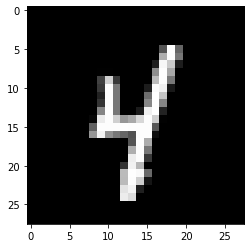

In [4]:
import matplotlib.pyplot as plt
plt.imshow(feature.numpy().reshape(28, 28), cmap = 'gray')

In [5]:
neuronios_entrada = 784
neuronios_oculta1 = 128

In [6]:
neuronios_oculta2 = 64

In [7]:
neuronios_oculta3 = neuronios_oculta1
neuronios_saida = neuronios_entrada

In [8]:
import tensorflow as tf
tf.random.set_seed(42)

In [10]:
inicializador = tf.keras.initializers.VarianceScaling()

In [11]:
W = {
    'encoder_oculta1': tf.Variable(inicializador([neuronios_entrada, neuronios_oculta1])),
    'encoder_oculta2': tf.Variable(inicializador([neuronios_oculta1, neuronios_oculta2])),
    'decoder_oculta3': tf.Variable(inicializador([neuronios_oculta2, neuronios_oculta3])),
    'decoder_saida': tf.Variable(inicializador([neuronios_oculta3, neuronios_saida]))
    }

In [12]:
b = {
    'encoder_oculta1': tf.Variable(inicializador([neuronios_oculta1])),
    'encoder_oculta2': tf.Variable(inicializador([neuronios_oculta2])),
    'decoder_oculta3': tf.Variable(inicializador([neuronios_oculta3])),
    'decoder_saida': tf.Variable(inicializador([neuronios_saida]))
    }

In [13]:
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)
var_list = [*list(W.values()), *list(b.values())]
batch_size = 128

In [14]:
for epoca in range(50):
    erro_epoca = 0.

    # Inicializar um contador de batches
    n_batches = 0
    for X_batch, _ in ds_train.batch(batch_size):
        n_batches += 1
        with tf.GradientTape() as tape:
            X_batch = tf.reshape(X_batch, (-1, 28*28))
            camada_oculta1 = tf.nn.relu(tf.add(tf.matmul(X_batch, W['encoder_oculta1']), b['encoder_oculta1']))
            camada_oculta2 = tf.nn.relu(tf.add(tf.matmul(camada_oculta1, W['encoder_oculta2']), b['encoder_oculta2']))
            camada_oculta3 = tf.nn.relu(tf.add(tf.matmul(camada_oculta2, W['decoder_oculta3']), b['decoder_oculta3']))
            camada_saida = tf.nn.relu(tf.add(tf.matmul(camada_oculta3, W['decoder_saida']), b['decoder_saida']))
            erro = tf.keras.losses.MSE(X_batch, camada_saida)
        gradientes = tape.gradient(erro, var_list)
        otimizador.apply_gradients(zip(gradientes, var_list))
        # Acumular o erro médio de cada batch para representar o erro da época
        erro_epoca += tf.reduce_mean(erro).numpy()
    # Terminada a época, dividir o erro acumulado pelo número de batches
    erro_epoca /= n_batches
    print('época: ' + str(epoca + 1) + ' erro: ' + str(erro_epoca))

época: 1 erro: 0.028262446406108737
época: 2 erro: 0.015265637726735459
época: 3 erro: 0.01356112690709992
época: 4 erro: 0.012760015726804352
época: 5 erro: 0.01229849224810852
época: 6 erro: 0.011975234499506986
época: 7 erro: 0.011752202602496533
época: 8 erro: 0.011582119390368462
época: 9 erro: 0.011455930378248316
época: 10 erro: 0.011345914841047737
época: 11 erro: 0.01125756101106911
época: 12 erro: 0.011185818133371344
época: 13 erro: 0.011124643312493113
época: 14 erro: 0.011074177372747901
época: 15 erro: 0.011032246692634341
época: 16 erro: 0.01099568176498291
época: 17 erro: 0.010963779510751462
época: 18 erro: 0.010933740829020294
época: 19 erro: 0.010907640382806375
época: 20 erro: 0.010887207280693532
época: 21 erro: 0.01086830381335798
época: 22 erro: 0.010849217949772694
época: 23 erro: 0.010832063319570602
época: 24 erro: 0.010816059355288427
época: 25 erro: 0.010797363265093837
época: 26 erro: 0.010772586812072599
época: 27 erro: 0.010736262062385774
época: 28 erro:

In [15]:
imagens_reais = []
imagens_codificadas = []
imagens_decodificadas = []

for X, _ in ds_train:
    imagens_reais.append(X.numpy().reshape(28, 28))
    
    X = tf.reshape(X, (-1, 28*28))
    camada_oculta1 = tf.nn.relu(tf.add(tf.matmul(X, W['encoder_oculta1']), b['encoder_oculta1']))
    camada_oculta2 = tf.nn.relu(tf.add(tf.matmul(camada_oculta1, W['encoder_oculta2']), b['encoder_oculta2']))
    imagens_codificadas.append(camada_oculta2.numpy().reshape(8, 8))

    camada_oculta3 = tf.nn.relu(tf.add(tf.matmul(camada_oculta2, W['decoder_oculta3']), b['decoder_oculta3']))
    camada_saida = tf.nn.relu(tf.add(tf.matmul(camada_oculta3, W['decoder_saida']), b['decoder_saida']))
    imagens_decodificadas.append(camada_saida.numpy().reshape(28, 28))

In [16]:
imagens_reais = np.asarray(imagens_reais)
imagens_reais.shape

(60000, 28, 28)

In [17]:
imagens_codificadas = np.asarray(imagens_codificadas)
imagens_codificadas.shape

(60000, 8, 8)

In [18]:
imagens_decodificadas = np.asarray(imagens_decodificadas)
imagens_decodificadas.shape

(60000, 28, 28)

In [19]:
import numpy as np
numero_imagens = 5
np.random.seed(42)
imagens_teste = np.random.randint(imagens_reais.shape[0], size = numero_imagens)
imagens_teste

array([56422, 15795,   860, 38158, 54343])

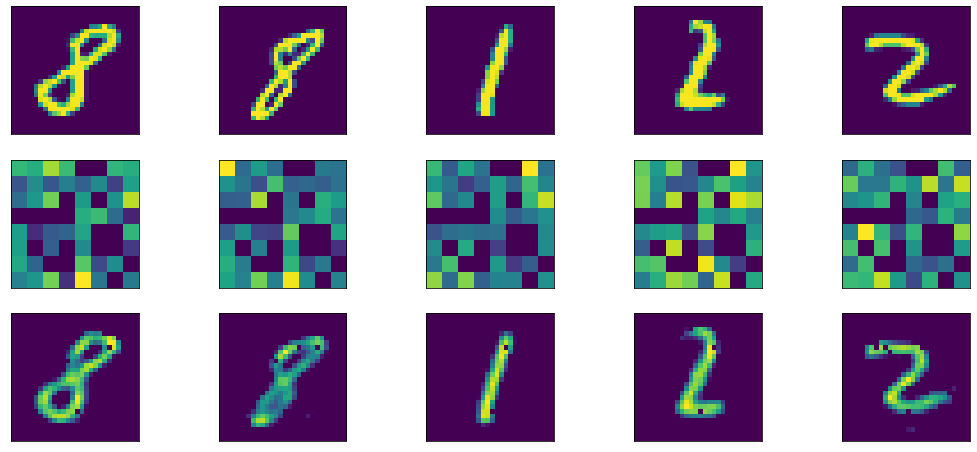

In [20]:
fig, axes = plt.subplots(3, 5, figsize = (18, 8))
imagens = [imagens_reais, imagens_codificadas, imagens_decodificadas]
# Cada linha vai plotar um tipo de imagem...
for row in range(3):
    # Cada coluna vai plotar um índice de imagens_teste...
    for col in range(5):
        axes[row][col].imshow(imagens[row][imagens_teste[col]])
        axes[row][col].set_xticks(())
        axes[row][col].set_yticks(())